## 2주차_Optimization과 회귀분석
### 첫번째 캐글 필사(Optimization)
- https://www.kaggle.com/pavansanagapati/automated-hyperparameter-tuning

#### 1. Introduction

- Hyperparameter은 학습과정 전에 어느 값이 세팅 되어야 하는지에 대한 것이다.
- Hyperparameter를 조정하기 위해 어떤 것을 최적화해야 하는가?

1. an estimator(regressor or classifier such as sklearn.svm.SVC())
2. a parameter space
3. a method for searching or sampling candidates
4. a cross-validation scheme
5. a score function

- Scikit-learn에서 후보들을 탐색하고 찾는 2가지의 일반적인 접근이 존재함

1. GridSearchCV: 값들이 주어졌을 때 모든 매개변수의 조합을 고려하는 방식이다. 
2. RandomizedSearchCV: 특정 분배와 함께 매개변수 공간으로부터 수많은 후보자들을 샘플링하는 방식이다. 추가적으로 적은 수의 매개변수 집합은 예측 성능에 있어 큰 영향을 끼친다.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv("../../../../data/creditcard/creditcard.csv", na_values = '#NAME?')

In [2]:
X = df[['V17', 'V9', 'V6', 'V12']]
Y = df['Class']

In [3]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

#### 2. Manual Search

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state = 101).fit(X_Train, Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test, predictionforest))
print(classification_report(Y_Test, predictionforest))
acc1 = accuracy_score(Y_Test, predictionforest)

[[85289    10]
 [   34   110]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.92      0.76      0.83       144

    accuracy                           1.00     85443
   macro avg       0.96      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



- 일반적인 manual search를 사용할 경우 우리의 경험과 판단에 기반해 매개변수를 선택해야한다. 모델을 평가하고 정확성을 측정해 그 과정을 계속 시도해야 한다. 

- Random Forest Classifier를 기반한 주요 매개변수는 다음과 같다.

1. criterion = the function used to evaluate the quality of a split(train_test_split 함수를 측정하는 것 같음)
2. max_depth = maximum number of levels allowed in each tree
3. max_features = maximum number of features considered when splitting a node
4. min_samples_leaf = minimum number of samples which can be stored in a tree leaf
5. min_samples_split = minimum number of samples necessary in a node to cause node splitting
6. n_estimators = number of trees in the ensemble

In [5]:
model = RandomForestClassifier(n_estimators=10, random_state = 101).fit(X_Train, Y_Train)
predictionforest = model.predict(X_Test)
print(confusion_matrix(Y_Test, predictionforest))
print(classification_report(Y_Test, predictionforest))
acc2 = accuracy_score(Y_Test, predictionforest)

[[85288    11]
 [   41   103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.90      0.72      0.80       144

    accuracy                           1.00     85443
   macro avg       0.95      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443



#### 3. Random Search
- 이 방식은 train/test 모델을 랜덤으로 나눠서 측정하는 방식이고 이때 Cross-Validation을 사용할 것이다. 
- Cross-Validation 방법 중 가장 흔한 것은 K-Fold Validation으로 training set을 N개로 나누고 반복적으로 N-1로 훈련시키고 남은 요소로 테스트하는 방식이다. 

In [6]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [2],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [4, 6, 8],
    'min_samples_split': [5, 7, 10],
    'n_estimators': [20]
}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, cv = 4, verbose = 1, random_state = 101, n_jobs = -1)
model.fit(X_Train, Y_Train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.2s finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [20]},
                   random_state=101, verbose=1)

<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

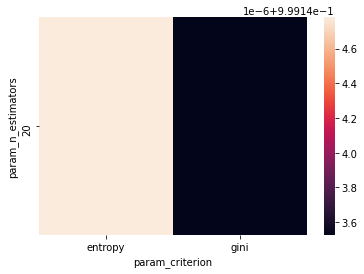

In [7]:
import seaborn as sns
table = pd.pivot_table(pd.DataFrame(model.cv_results_), values = 'mean_test_score', index = 'param_n_estimators', columns = 'param_criterion')
sns.heatmap(table)

In [8]:
predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test, predictionforest))
print(classification_report(Y_Test, predictionforest))
acc3 = accuracy_score(Y_Test, predictionforest)

[[85284    15]
 [   61    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.85      0.58      0.69       144

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



#### 4. Grid Search
- 이 방식에서 매개변수 조합의 각각에 모델을 훈련/평가를 하게 된다.

In [9]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [2],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [4, 6, 8],
    'min_samples_split': [5, 7, 10],
    'n_estimators': [20]
}

clf = RandomForestClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 4, verbose = 5, n_jobs = -1)
model.fit(X_Train, Y_Train)

predictionforest = model.best_estimator_.predict(X_Test)
print(confusion_matrix(Y_Test, predictionforest))
print(classification_report(Y_Test, predictionforest))
acc4 = accuracy_score(Y_Test, predictionforest)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   41.0s finished


[[85279    20]
 [   47    97]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.83      0.67      0.74       144

    accuracy                           1.00     85443
   macro avg       0.91      0.84      0.87     85443
weighted avg       1.00      1.00      1.00     85443



#### 5. Automated Hyperparameter Tuning

1) Bayesian Optimization using HyperOpt

In [10]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'max_depth': hp.quniform('max_depth', 10, 12, 10),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split': hp.uniform('min_samples_split', 0, 1),
    'n_estimators': hp.choice('n_estimators', [10, 50])
}

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'],
                                  max_depth = space['max_depth'],
                                  max_features = space['max_features'],
                                  min_samples_leaf = space['min_samples_leaf'],
                                  min_samples_split = space['min_samples_split'],
                                  n_estimators = space['n_estimators'])
    accuracy = cross_val_score(model, X_Train, Y_Train, cv = 4).mean()
    
    return {'loss': -accuracy, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn = objective,
           space = space,
           algo = tpe.suggest,
           max_evals = 20,
           trials = trials)
best

100%|██████████| 20/20 [00:57<00:00,  2.89s/trial, best loss: -0.9982544491482915]


{'criterion': 0,
 'max_depth': 10.0,
 'max_features': 0,
 'min_samples_leaf': 0.19229348647911865,
 'min_samples_split': 0.2852019509946798,
 'n_estimators': 0}

In [11]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 75, 3: 100, 4: 125}
trainedforest = RandomForestClassifier(
    criterion = crit[best['criterion']],
    max_depth = best['max_depth'],
    max_features = feat[best['max_features']],
    min_samples_leaf = best['min_samples_leaf'],
    min_samples_split = best['min_samples_split'],
    n_estimators = est[best['n_estimators']]
).fit(X_Train, Y_Train)

predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test, predictionforest))
print(classification_report(Y_Test, predictionforest))
acc5 = accuracy_score(Y_Test, predictionforest)

[[85299     0]
 [  144     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.00      0.00      0.00       144

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from tpot import TPOTClassifier

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto'],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': [10]}
               
tpot_classifier = TPOTClassifier(
    generations= 4, population_size= 24, offspring_size= 12,  
    verbosity= 2, early_stop= 12,  
    config_dict={'sklearn.ensemble.RandomForestClassifier': parameters}, 
    cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_Train,Y_Train) 

/opt/anaconda3/lib/python3.7/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Version 0.11.6.post3 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


Optimization Progress:   0%|          | 0/72 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9992526233422283

Generation 2 - Current best internal CV score: 0.9992526233422283

Generation 3 - Current best internal CV score: 0.9992526233422283

Generation 4 - Current best internal CV score: 0.9992526233422283

Best pipeline: RandomForestClassifier(RandomForestClassifier(input_matrix, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=10), criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [2],
                                                                        'max_features': ['auto'],
                                                                        'min_samples_leaf': [4,
                                                                                             12],
                                                                        'min_samples_split': [5,
                                                                                              10],
                                                                        'n_estimators': [10]}},
               cv=4, early_stop=12, generations=4, offspring_size=12,
               population_size=24, scoring='accuracy', verbosity

In [14]:
accuracy = tpot_classifier.score(X_Test, Y_Test)
print(accuracy)

0.9992743700478681


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
def DL_Model(activation = 'linear', neurons = 5, optimizer = 'Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim = 4, activation = activation))
    model.add(Dense(neurons, activation = activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    return model

In [21]:
activation = ['softmax', 'relu']
neurons = [5, 10]
optimizer = ['Adam', 'Adamax']
param_grid = dict(
    activation = activation,
    neurons = neurons,
    optimizer = optimizer
)

clf = KerasClassifier(
    build_fn = DL_Model,
    epochs = 5, 
    batch_size = 1024,
    verbose = 2
)

In [22]:
model = GridSearchCV(
    estimator = clf,
    param_grid=param_grid,
    n_jobs = -1
)
model.fit(X_Train, Y_Train)

Epoch 1/5
 - 1s - loss: 0.5309 - accuracy: 0.7781
Epoch 2/5
 - 1s - loss: 0.1449 - accuracy: 0.9976
Epoch 3/5
 - 1s - loss: 0.0576 - accuracy: 0.9982
Epoch 4/5
 - 1s - loss: 0.0238 - accuracy: 0.9983
Epoch 5/5
 - 1s - loss: 0.0152 - accuracy: 0.9985


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd5ba6e4850>,
             n_jobs=-1,
             param_grid={'activation': ['softmax', 'relu'], 'neurons': [5, 10],
                         'optimizer': ['Adam', 'Adamax']})

In [23]:
print("Max Accuracy Registered: {} using {}".format(
    round(model.best_score_, 3),
    model.best_params_
))

Max Accuracy Registered: 0.999 using {'activation': 'relu', 'neurons': 10, 'optimizer': 'Adam'}


In [26]:
prediction_test = model.predict(X_Test)
print(confusion_matrix(Y_Test,prediction_test))
print(classification_report(Y_Test,prediction_test))
accuracy_ANN = accuracy_score(Y_Test,prediction_test)

[[85293     6]
 [  109    35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.85      0.24      0.38       144

    accuracy                           1.00     85443
   macro avg       0.93      0.62      0.69     85443
weighted avg       1.00      1.00      1.00     85443



#### 6. Optuna

In [28]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import optuna

def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target
    
    classifier_name = trial.suggest_categorical('classifier', ['SVC', ['RandomForest']])
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth,
            n_estimators=10
        )
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-01-19 19:27:18,893] A new study created in memory with name: no-name-93ab8688-ac23-4b02-b532-ac1ec197a5fe
/opt/anaconda3/lib/python3.7/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ['RandomForest'] which is of type list.
  warnings.warn(message)
[I 2021-01-19 19:27:18,898] Trial 0 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 16.177857990572225}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:18,900] Trial 1 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 3.8503993696072}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:18,903] Trial 2 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 4498.159152111135}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27

[I 2021-01-19 19:27:19,168] Trial 38 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 48039.1293755097}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,176] Trial 39 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 22729.186768025134}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,184] Trial 40 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 0.19494366417330358}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,191] Trial 41 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 0.004793585711229298}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,199] Trial 42 finished with value: 0.9992743700478681 and parameters: {'classifier': 'SVC', 'svc_c': 0.0001766343273771538}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,207] Tri

[I 2021-01-19 19:27:19,468] Trial 78 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 28.245064286212877}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,477] Trial 79 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 31.45232837525396}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,484] Trial 80 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 11.15706892166058}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,493] Trial 81 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 21.808492176097886}. Best is trial 0 with value: 0.9992743700478681.
[I 2021-01-19 19:27:19,500] Trial 82 finished with value: 0.9992743700478681 and parameters: {'classifier': ['RandomForest'], 'rf_max_depth': 11.3450337202600

#### 7. Tune

In [42]:
pip install 'ray[tune]' torch torchvision

     |████████████████████████████████| 49.2 MB 12.4 MB/s eta 0:00:01
  Using cached opencensus-0.7.12-py2.py3-none-any.whl (127 kB)
  Using cached aioredis-1.3.1-py3-none-any.whl (65 kB)
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
  Using cached colorful-0.5.4-py2.py3-none-any.whl (201 kB)
  Using cached py_spy-0.3.4-py2.py3-none-macosx_10_14_x86_64.whl (1.5 MB)
  Using cached aiohttp_cors-0.7.0-py3-none-any.whl (27 kB)
  Using cached gpustat-0.6.0.tar.gz (78 kB)
  Using cached tensorboardX-2.1-py2.py3-none-any.whl (308 kB)
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Using cached opencensus_context-0.1.2-py2.py3-none-any.whl (4.4 kB)
  Using cached nvidia-ml-py3-7.352.0.tar.gz (19 kB)
  Using cached blessings-1.7-py3-none-any.whl (18 kB)
  Created wheel for gpustat: filename=gpustat-0.6.0-py3-none-any.whl size=12617 sha256=78745cc16517fbf230ec40440c2dc2c5c2e6acb9d5106713193e4a90d161c568
  Stored in directory: /Users/kimjinsung/Library/Caches/pip/wheels/e6/67/a

In [43]:
import torch.optim as optim
from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, train, test

In [44]:
def train_mnist(config):
    train_loader, test_loader = get_data_loaders()
    model = ConvNet()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        tune.report(mean_accuracy=acc)

In [45]:
analysis = tune.run(train_mnist, config={
    "lr": tune.grid_search([0.001, 0.01, 0.1])
})
print("Best config: ", analysis.get_best_config(metirc="mean_accuracy"))

2021-01-19 19:44:00,412	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8265
2021-01-19 19:44:02,921	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lr
train_mnist_3ee39_00000,RUNNING,,0.001


0it [00:00, ?it/s]


(pid=15234) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /Users/kimjinsung/data/MNIST/raw/train-images-idx3-ubyte.gz


100%|█████████▉| 9904128/9912422 [00:01<00:00, 19816382.84it/s]


(pid=15234) Extracting /Users/kimjinsung/data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/kimjinsung/data/MNIST/raw


(pid=15234) 
0it [00:00, ?it/s]


(pid=15234) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /Users/kimjinsung/data/MNIST/raw/train-labels-idx1-ubyte.gz


(pid=15234) 
  0%|          | 0/28881 [00:00<?, ?it/s]
(pid=15234) 
 57%|█████▋    | 16384/28881 [00:00<00:00, 97201.99it/s]
(pid=15234) 
0it [00:00, ?it/s]


(pid=15234) Extracting /Users/kimjinsung/data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/kimjinsung/data/MNIST/raw
(pid=15234) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /Users/kimjinsung/data/MNIST/raw/t10k-images-idx3-ubyte.gz


(pid=15234) 
(pid=15234) 
  0%|          | 0/1648877 [00:00<?, ?it/s]
(pid=15234) 
(pid=15234) 
 12%|█▏        | 204800/1648877 [00:00<00:00, 2025216.28it/s]
(pid=15234) 
(pid=15234) 
 63%|██████▎   | 1040384/1648877 [00:00<00:00, 5568912.55it/s]
(pid=15234) 
(pid=15234) 
(pid=15234) 
0it [00:00, ?it/s]


(pid=15234) Extracting /Users/kimjinsung/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/kimjinsung/data/MNIST/raw
(pid=15234) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /Users/kimjinsung/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


(pid=15234) 
(pid=15234) 
(pid=15234) 
  0%|          | 0/4542 [00:02<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370126481/work/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=15234)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
32768it [00:04, 7087.72it/s]                            
1654784it [00:03, 415051.35it/s]                              
8192it [00:03, 2640.99it/s]             
(pid=15234) 2021-01-19 19:44:09,780	ERROR function_runner.py:254 -- Runner Thread raise

(pid=15234) Extracting /Users/kimjinsung/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/kimjinsung/data/MNIST/raw
(pid=15234) Processing...
(pid=15234) Done!
Result for train_mnist_3ee39_00002:
  {}
  


(pid=15233) 2021-01-19 19:44:09,816	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=15233) Traceback (most recent call last):
(pid=15233)   File "/opt/anaconda3/lib/python3.7/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=15233)     self._entrypoint()
(pid=15233)   File "/opt/anaconda3/lib/python3.7/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=15233)     self._status_reporter.get_checkpoint())
(pid=15233)   File "/opt/anaconda3/lib/python3.7/site-packages/ray/tune/function_runner.py", line 575, in _trainable_func
(pid=15233)     output = fn()
(pid=15233)   File "<ipython-input-44-7ca1dfcabe9c>", line 3, in train_mnist
(pid=15233) NameError: name 'ConvNet' is not defined
(pid=15233) Exception in thread Thread-2:
(pid=15233) Traceback (most recent call last):
(pid=15233)   File "/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=15233)     self.run()
(pid=15233)   File "/opt/anaconda3/lib/python3.

Result for train_mnist_3ee39_00000:
  {}
  
Result for train_mnist_3ee39_00001:
  {}
  


9920512it [00:06, 1588129.83it/s]                              


TuneError: ('Trials did not complete', [train_mnist_3ee39_00000, train_mnist_3ee39_00001, train_mnist_3ee39_00002])

#### 8. Sherpa

In [39]:
pip install parameter-sherpa

     |████████████████████████████████| 513 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 29.6 MB/s eta 0:00:01
  Created wheel for parameter-sherpa: filename=parameter_sherpa-1.0.6-py2.py3-none-any.whl size=542119 sha256=750cba1ba8c1e29e86ba3236998bfc24b51296335720e8077597425c7b363902
  Stored in directory: /Users/kimjinsung/Library/Caches/pip/wheels/96/d9/cb/99569566e5e9b3ef0265ba4cbce3ff16f7692988833aa942f5
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83621 sha256=f2f1540ef92b7cc130983f744d3d5d3383a950f6494d665349483a15034d7bee
  Stored in directory: /Users/kimjinsung/Library/Caches/pip/wheels/e6/fa/d1/f9652b5af79f769a0ab74dbead7c7aea9a93c6bc74543fd3ec
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102552 sha256=f86a3283fdb8fdd719d84a3e794576ed45c484deb03b4da6a2f39c7c09c35b

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

In [5]:
parameters = [sherpa.Discrete('n_estimators', [2, 50]),
              sherpa.Choice('criterion', ['gini', 'entropy']),
              sherpa.Continuous('max_features', [0.1, 0.9])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,model_type='GP_MCMC',acquisition_type='EI_MCMC',max_num_trials=10)

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    clf = RandomForestClassifier(criterion=trial.parameters['criterion'],
                                 max_features=trial.parameters['max_features'],
                                 n_estimators=trial.parameters['n_estimators'],
                                 random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    print("Score: ", scores.mean())
    study.add_observation(trial, iteration=1, objective=scores.mean())
    study.finalize(trial)
print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://218.38.137.28:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Trial  1  with parameters  {'n_estimators': 3, 'criterion': 'entropy', 'max_features': 0.19239756814654047}
Score:  0.9349945660611706
Trial  2  with parameters  {'n_estimators': 21, 'criterion': 'entropy', 'max_features': 0.4970068701755569}
Score:  0.9630957925787922
Trial  3  with parameters  {'n_estimators': 5, 'criterion': 'gini', 'max_features': 0.6409155700963638}
Score:  0.9490917559385188
Trial  4  with parameters  {'n_estimators': 44, 'criterion': 'gini', 'max_features': 0.6980255317214328}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648967551622418
Trial  5  with parameters  {'n_estimators': 44, 'criterion': 'gini', 'max_features': 0.2447209954513944}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648812296227295
Trial  6  with parameters  {'n_estimators': 44, 'criterion': 'gini', 'max_features': 0.6534034853521852}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648812296227295
Trial  7  with parameters  {'n_estimators': 41, 'criterion': 'entropy', 'max_features': 0.4965014876300164}


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Score:  0.9648812296227295
Trial  8  with parameters  {'n_estimators': 13, 'criterion': 'gini', 'max_features': 0.9}
Score:  0.9595714951094549


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


### 두번째 캐글 필사
- https://www.kaggle.com/vikasukani/titanic-5-machine-learning-models

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("dark")

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#### 1. Data Collection

In [34]:
trainDF = pd.read_csv("../../../../data/titanic/train.csv")

trainDF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
testDF = pd.read_csv("../../../../data/titanic/test.csv")

testDF.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
def show_shape(train, test):
    print(" Shape of Training DF", train.shape)
    print("")
    print(" Shape of Testing DF", test.shape)

In [37]:
show_shape(trainDF, testDF)

 Shape of Training DF (891, 12)

 Shape of Testing DF (418, 11)


In [38]:
def show_info(train, test):
    print("Information of Training DF"+"-"*10)
    print(train.info())
    print("")
    print("")
    print("")
    print("Information of Testing DF"+"-"*10)
    print(test.info())

In [39]:
show_info(trainDF, testDF)

Information of Training DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None



Information of Testing DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------     

#### 2. Feature Engineering

In [40]:
removedFeatures = ['Name', 'Ticket', 'Cabin']

trainDF = trainDF.drop(removedFeatures, axis=1)
testDF = testDF.drop(removedFeatures, axis=1)

trainDF.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [41]:
trainDF['Age'] = trainDF['Age'].fillna(trainDF['Age'].mean())
testDF['Age'] = testDF['Age'].fillna(testDF['Age'].mean())

In [42]:
trainDF['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [43]:
trainDF['Embarked'] = trainDF['Embarked'].fillna("S")

In [44]:
show_info(trainDF, testDF)

Information of Training DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB
None



Information of Testing DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          

#### 3. Visualization

In [45]:
fig = px.bar(trainDF.Survived.value_counts())
fig.show()

In [46]:
fig = px.bar(trainDF.groupby(['Survived']).count())
fig.show()

In [47]:
fig = px.histogram(trainDF, x="Survived", y="Pclass", color="Pclass")
fig.show()

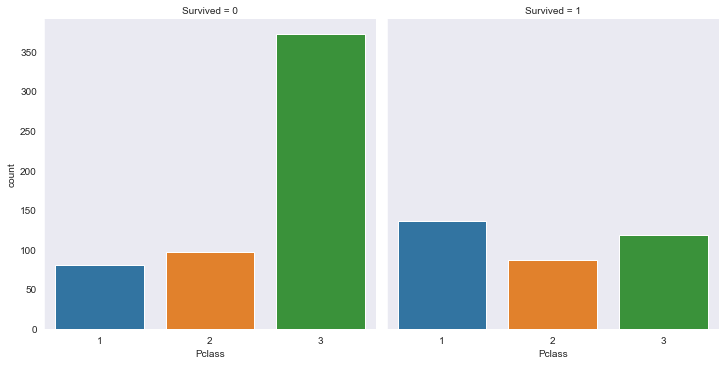

In [48]:
sns.catplot(x="Pclass", col="Survived", data=trainDF, kind="count")
plt.show()

In [49]:
fig = px.histogram(trainDF, x="Pclass", y="Survived", color="Pclass")
fig.show()

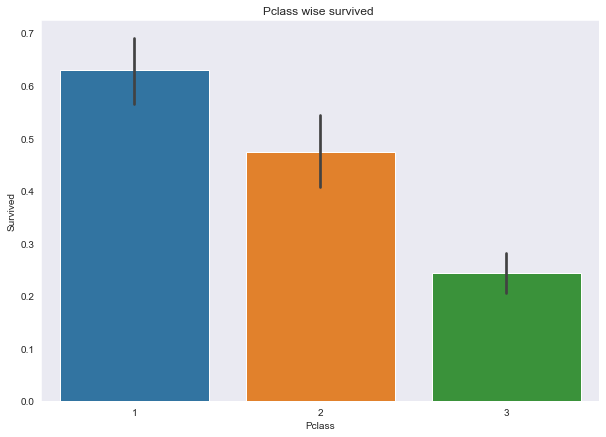

In [50]:
plt.figure(figsize=(10, 7))
sns.barplot(x="Pclass", y="Survived", data=trainDF)
plt.title("Pclass wise survived ")
plt.show()

In [51]:
fig = px.bar(trainDF, x="Sex", y="Survived", color="Sex")
fig.show()

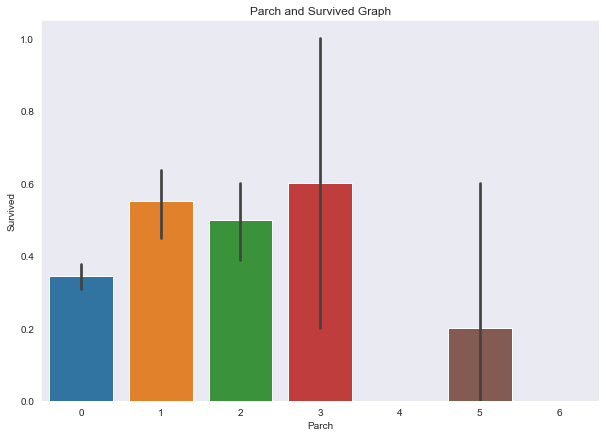

In [52]:
plt.figure(figsize=(10, 7))
sns.barplot(x="Parch", y="Survived", data=trainDF)
plt.title("Parch and Survived Graph")
plt.show()

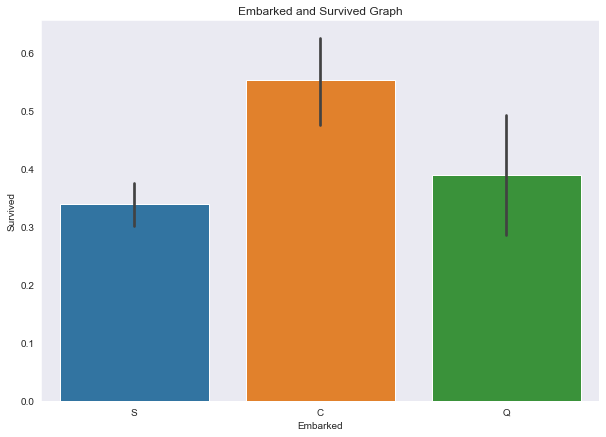

In [53]:
plt.figure(figsize=(10, 7))
sns.barplot(x="Embarked", y="Survived", data=trainDF)
plt.title("Embarked and Survived Graph")
plt.show()

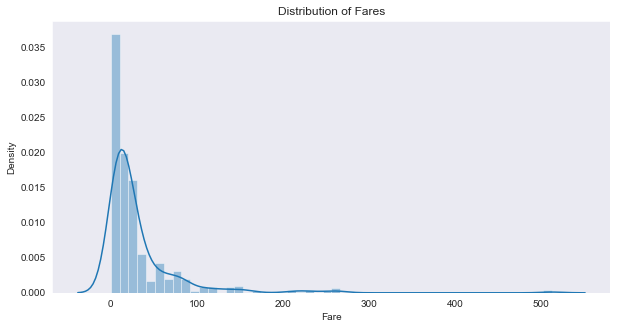

In [54]:
plt.figure(figsize=(10, 5))
sns.distplot(trainDF.Fare)
plt.title("Distribution of Fares")
plt.show()

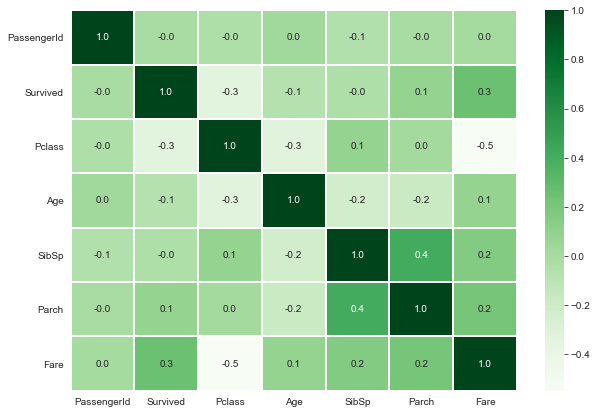

In [55]:
plt.figure(figsize=(10, 7))
sns.heatmap(trainDF.corr(), cmap="Greens", linewidths=1, annot=True, fmt=".1f")

fig=plt.gcf()
plt.show()

In [56]:
show_info(trainDF, testDF)

Information of Training DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB
None



Information of Testing DF----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          

In [57]:
testDF["Fare"] = testDF["Fare"].fillna(testDF["Fare"].mean())

In [58]:
trainDF["Sex"] = trainDF["Sex"].replace({"male":0, "female": 1})
testDF["Sex"] = testDF["Sex"].replace({"male": 0, "female": 1})

In [59]:
print(testDF['Embarked'].value_counts())
print(trainDF["Embarked"].value_counts())

S    270
C    102
Q     46
Name: Embarked, dtype: int64
S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [60]:
trainDF["Embarked"] = trainDF["Embarked"].replace({"C": 1, "S": 2, "Q": 3})
testDF["Embarked"] = testDF["Embarked"].replace({"C": 1, "S": 2, "Q": 3})

In [61]:
print(trainDF.head())
print(testDF.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0            1         0       3    0  22.0      1      0   7.2500         2
1            2         1       1    1  38.0      1      0  71.2833         1
2            3         1       3    1  26.0      0      0   7.9250         2
3            4         1       1    1  35.0      1      0  53.1000         2
4            5         0       3    0  35.0      0      0   8.0500         2
   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0          892       3    0  34.5      0      0   7.8292         3
1          893       3    1  47.0      1      0   7.0000         2
2          894       2    0  62.0      0      0   9.6875         3
3          895       3    0  27.0      0      0   8.6625         2
4          896       3    1  22.0      1      1  12.2875         2


#### 4. Model Prediction

In [62]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [63]:
X_train = trainDF.drop(["PassengerId", "Survived"], axis=1)
y_train = trainDF["Survived"]
X_test = testDF.drop(["PassengerId"], axis=1)

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(891, 7)
(891,)
(418, 7)


In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [67]:
pred = model.predict(X_test)
pred.shape

(418,)

In [68]:
accu = model.score(X_train, y_train)
print("Model Prediction Score", (accu*100).round(2))

Model Prediction Score 98.2


#### 5. Model Submission

In [69]:
dict = {
    "PassengerId": testDF["PassengerId"],
    "Survived": pred
}

new_submission = pd.DataFrame(dict, )
new_submission.shape

(418, 2)

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [71]:
def model_wise_predict(models):
    ans_score = []
    for mdl, filename in models:
        m = mdl
        m.fit(X_train, y_train)
        pred = m.predict(X_test)
        m_accuracy = m.score(X_train, y_train)
        ans_score.append((m_accuracy*100).round(2))
        
        dict = {
            "PassengerId": testDF["PassengerId"],
            "Survived": pred
        }
        new_submission = pd.DataFrame(dict,)
    
    return ans_score

In [73]:
models = [
    (RandomForestClassifier(n_estimators=300, max_depth=20, random_state=5), "DTC_submission.csv"),
    (RandomForestClassifier(), 'RFC_submission.csv'),
    (LogisticRegression(), 'LR_submission.csv'),
    (LinearSVC(), 'SVC_submission.csv'),
    (GaussianNB(), 'GNB_submission.csv'),
    (SGDClassifier(), 'SGD_submission.csv'),
    (KNeighborsClassifier(), 'KNC_submission.csv')
]

data = model_wise_predict(models)
print("scores are", data)

scores are [98.2, 98.2, 79.91, 68.91, 79.01, 64.2, 80.81]


In [75]:
list_model_name = [
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'LogisticRegression', 
    'LinearSVC',
    'GaussianNB',
    'SGDClassifier', 
    'KNeighborsClassifier'
]

In [76]:
print(X_train, y_train)

     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
0         3    0  22.000000      1      0   7.2500         2
1         1    1  38.000000      1      0  71.2833         1
2         3    1  26.000000      0      0   7.9250         2
3         1    1  35.000000      1      0  53.1000         2
4         3    0  35.000000      0      0   8.0500         2
..      ...  ...        ...    ...    ...      ...       ...
886       2    0  27.000000      0      0  13.0000         2
887       1    1  19.000000      0      0  30.0000         2
888       3    1  29.699118      1      2  23.4500         2
889       1    0  26.000000      0      0  30.0000         1
890       3    0  32.000000      0      0   7.7500         3

[891 rows x 7 columns] 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [77]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rfc_model = RandomForestClassifier(random_state=45)

rfc_params_grid = {
    'n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'max_depth': np.random.randint(1, (len(X_train.columns)*.85),20),
    'max_features': np.random.randint(1, len(X_train.columns),20),
    'min_samples_split':[2,4,6,8,10,20,40,60,100], 
    'min_samples_leaf':[1,3,5,7,9],
    'criterion': ["gini", "entropy"]
}

gscv_random_classifier = RandomizedSearchCV(rfc_model, rfc_params_grid, cv = 5, n_jobs = -1, verbose = 5)
gscv_random_classifier.fit(X_train, y_train)

pred = gscv_random_classifier.predict(X_test)

print("--------------- START ---------------")

print(gscv_random_classifier.best_estimator_)
print(gscv_random_classifier.best_score_)
print(gscv_random_classifier.best_params_)
bestEstimator = gscv_random_classifier.best_estimator_
bestParams = gscv_random_classifier.best_params_

print("--------------- OVER ---------------")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:    9.0s remaining:    2.8s


--------------- START ---------------
RandomForestClassifier(criterion='entropy', max_depth=3, max_features=4,
                       min_samples_leaf=3, random_state=45)
0.8204193082669011
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 3, 'criterion': 'entropy'}
--------------- OVER ---------------


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.7s finished


In [78]:
m = RandomForestClassifier(criterion="entropy", max_depth=3, max_features=6, min_samples_split=4, n_estimators=1250, random_state=35)
m.fit(X_train, y_train)

pred = m.predict(X_test)

print("Acc: ", m.score(X_train, y_train))

dict = {
    "PassengerId": testDF["PassengerId"],
    "Survived": pred
}

new_submission = pd.DataFrame(dict, )
new_submission.to_csv("Random-Forest-GSCV-Hyper Tunning.csv", index=False)

Acc:  0.8294051627384961


In [79]:
modelDF = pd.DataFrame({"Model_Name": list_model_name, "Pred_Score": data})
modelDF.sort_values(by="Pred_Score", ascending=False)
modelDF

,Model_Name,Pred_Score
0,DecisionTreeClassifier,98.20
1,RandomForestClassifier,98.20
2,LogisticRegression,79.91
3,LinearSVC,68.91
4,GaussianNB,79.01
5,SGDClassifier,64.20
6,KNeighborsClassifier,80.81
